# DeepShot: Data Exploration

## Introduction

Exploratory Data Analysis (EDA) is a crucial step in our NBA shot prediction project. In this notebook, we'll explore the features we've created to understand their distributions, relationships, and potential predictive power.

Our exploration will focus on several key areas:

1. **Spatial Patterns**: How does court location affect shooting efficiency?
2. **Temporal Patterns**: How do time-related factors influence shot success?
3. **Player Analysis**: What player characteristics impact shooting performance?
4. **Game Context Analysis**: How do situational factors affect shooting?
5. **Feature Importance**: Which features have the strongest relationship with shot success?

Through this exploration, we aim to gain insights that will inform our modeling approach and help us understand the factors that influence NBA shooting. We expect to find that spatial factors (particularly shot distance) have the strongest influence on shot success, followed by player-specific factors and game context.

In [2]:
# ##HIDE##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats

# Set visualization style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Create directories
processed_dir = Path('../data/processed')
features_dir = processed_dir / 'features'
for directory in [processed_dir, features_dir]:
    directory.mkdir(parents=True, exist_ok=True)

In [3]:
# Load shot data with features
shots = pd.read_csv(features_dir / 'shots_with_features.csv')
player = pd.read_csv(features_dir / 'player_features.csv')
team = pd.read_csv(features_dir / 'team_features.csv')

print(f"Loaded {len(shots)} shots, {len(player)} player records, {len(team)} team records")
shots.head()

Loaded 4650091 shots, 29576 player records, 1788 team records


,SEASON_1,SEASON_2,TEAM_ID,team_name,PLAYER_ID,player_name,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,shooting_pct,prior_pct,true_shooting,usage_rate,experience,career_stage,win_pct,offensive_rating,defensive_rating,playing_style
0,2009,2008-09,1610612744,Golden State Warriors,201627,ANTHONY MORROW,G,SG,2009-04-15,20801229,...,NaN,0.5,0.588358,0.413518,0.0,Rookie (0-2),0.5,108.6,0.0,Slow-Inside
1,2009,2008-09,1610612744,Golden State Warriors,101235,KELENNA AZUBUIKE,F,SF,2009-04-15,20801229,...,0.564593,0.5,0.561982,0.438215,2.0,Rookie (0-2),0.5,108.6,0.0,Slow-Inside
2,2009,2008-09,1610612756,Phoenix Suns,255,GRANT HILL,F,SF,2009-04-15,20801229,...,0.688525,0.5,0.583835,0.396548,14.0,Veteran (10+),0.5,109.4,0.0,Slow-Inside
3,2009,2008-09,1610612739,Cleveland Cavaliers,200789,DANIEL GIBSON,G,PG,2009-04-15,20801219,...,0.471698,0.5,0.518731,0.348657,2.0,Rookie (0-2),0.5,100.3,0.0,Slow-Inside
4,2009,2008-09,1610612756,Phoenix Suns,255,GRANT HILL,F,SF,2009-04-15,20801229,...,0.426966,0.5,0.583835,0.396548,14.0,Veteran (10+),0.5,109.4,0.0,Slow-Inside


## Data Overview

Before diving into specific analyses, let's get a better understanding of our dataset by examining its structure, basic statistics, and quality characteristics. This overview will help us identify any remaining data issues and understand the scope of our analysis.

In [4]:
# Check for missing values
missing_values = shots.isnull().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Basic statistics for numeric columns
shots.describe()

Columns with missing values:
shooting_pct     745530
true_shooting    297660
usage_rate       297660
experience       297660
career_stage     297660
dtype: int64


,SEASON_1,TEAM_ID,PLAYER_ID,GAME_ID,loc_x,loc_y,SHOT_DISTANCE,quarter,MINS_LEFT,SECS_LEFT,...,time_remaining_seconds,end_of_period,shooting_pct,prior_pct,true_shooting,usage_rate,experience,win_pct,offensive_rating,defensive_rating
count,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,4.650091e+06,...,4.650091e+06,4.650091e+06,3.904561e+06,4650091.0,4.352431e+06,4.352431e+06,4.352431e+06,4650091.0,4.650091e+06,4650091.0
mean,2.014214e+03,1.610613e+09,4.103645e+05,2.132202e+07,9.726408e-02,1.240319e+01,1.260702e+01,2.484101e+00,5.336104e+00,2.876802e+01,...,3.489343e+02,4.834787e-02,4.590479e-01,0.5,5.441507e-01,4.760403e-01,5.567962e+00,0.5,1.036231e+02,0.0
std,6.092693e+00,8.648372e+00,6.125469e+05,6.092661e+05,1.029289e+01,8.564057e+00,1.013096e+01,1.137472e+00,3.467863e+00,1.745068e+01,...,2.089087e+02,2.145003e-01,1.290713e-01,0.0,5.750766e-02,1.251382e-01,4.612451e+00,0.0,7.565563e+00,0.0
min,2.004000e+03,1.610613e+09,1.500000e+01,2.030000e+07,-2.500000e+01,5.000000e-02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.5,0.000000e+00,0.000000e+00,0.000000e+00,0.5,8.540000e+01,0.0
25%,2.009000e+03,1.610613e+09,2.499000e+03,2.080052e+07,-2.900000e+00,5.875000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.400000e+01,...,1.670000e+02,0.000000e+00,3.680556e-01,0.5,5.152188e-01,3.866487e-01,2.000000e+00,0.5,9.760000e+01,0.0
50%,2.014000e+03,1.610613e+09,2.015710e+05,2.130113e+07,0.000000e+00,8.050000e+00,1.300000e+01,2.000000e+00,5.000000e+00,2.900000e+01,...,3.500000e+02,0.000000e+00,4.307692e-01,0.5,5.456056e-01,4.656685e-01,5.000000e+00,0.5,1.028000e+02,0.0
75%,2.019000e+03,1.610613e+09,2.035070e+05,2.180114e+07,2.900000e+00,1.875000e+01,2.300000e+01,3.000000e+00,8.000000e+00,4.400000e+01,...,5.310000e+02,0.000000e+00,5.562914e-01,0.5,5.768397e-01,5.557068e-01,8.000000e+00,0.5,1.100000e+02,0.0
max,2.024000e+03,1.610613e+09,1.642013e+06,2.230123e+07,2.500000e+01,9.365000e+01,8.900000e+01,8.000000e+00,1.200000e+01,5.900000e+01,...,7.200000e+02,1.000000e+00,1.000000e+00,0.5,1.500000e+00,1.666667e+00,7.000000e+01,0.5,1.233000e+02,0.0


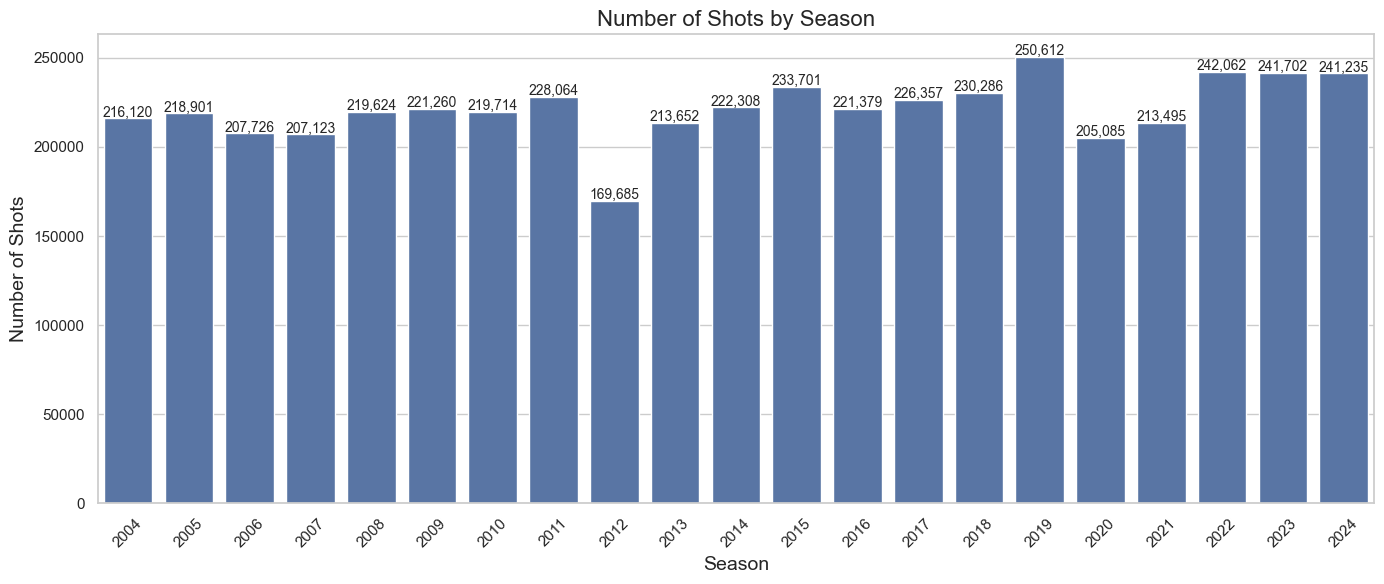

In [5]:
# Distribution of shots by season
season_counts = shots['season'].value_counts().sort_index()
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=season_counts.index, y=season_counts.values)
plt.title('Number of Shots by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Number of Shots', fontsize=14)
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(season_counts.values):
    ax.text(i, v + 1000, f"{v:,}", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

Overall shot success rate: 45.61%


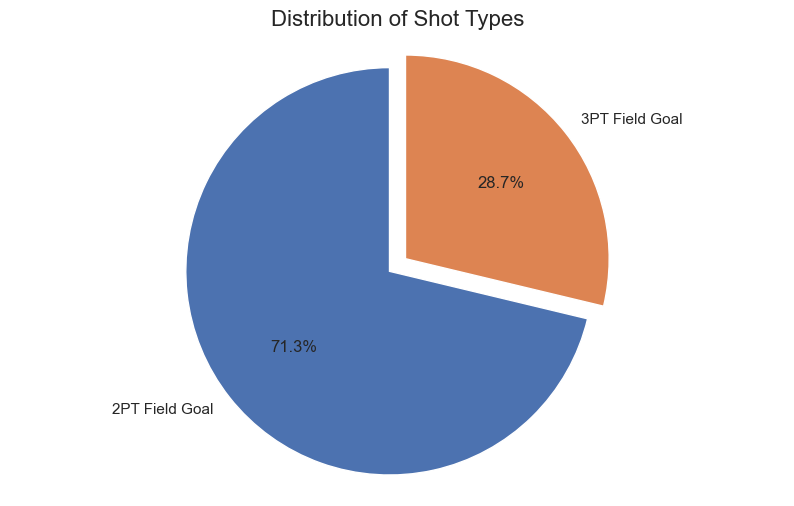

In [6]:
# Overall shot success rate
overall_success = shots['shot_made'].mean() * 100
print(f"Overall shot success rate: {overall_success:.2f}%")

# Shot type distribution
if 'SHOT_TYPE' in shots.columns:
    shot_type_counts = shots['SHOT_TYPE'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.pie(shot_type_counts, labels=shot_type_counts.index, autopct='%1.1f%%', startangle=90, explode=[0.05] * len(shot_type_counts))
    plt.title('Distribution of Shot Types', fontsize=16)
    plt.axis('equal')
    plt.show()

## Spatial Analysis

Court location is expected to be one of the most important factors in predicting shot success. In this section, we'll explore how shot location affects shooting efficiency, visualize shot distribution across the court, and identify high-efficiency shooting zones.

In [7]:
# Shot success rate by court zone
zone_success = shots.groupby('court_zone')['shot_made'].agg(['count', 'mean']).reset_index()
zone_success.columns = ['court_zone', 'shots', 'success_rate']
zone_success['success_rate'] = zone_success['success_rate'] * 100
zone_success = zone_success.sort_values('success_rate', ascending=False)
zone_success

,court_zone,shots,success_rate
3,Restricted Area,3507,63.986313
2,Paint,1747890,57.723999
0,Long Mid-Range,805287,40.428071
1,Mid-Range,860765,39.336869
4,Three-Point,1232642,36.152508


/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/3334514108.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='court_zone', y='success_rate', data=zone_success, palette='viridis')


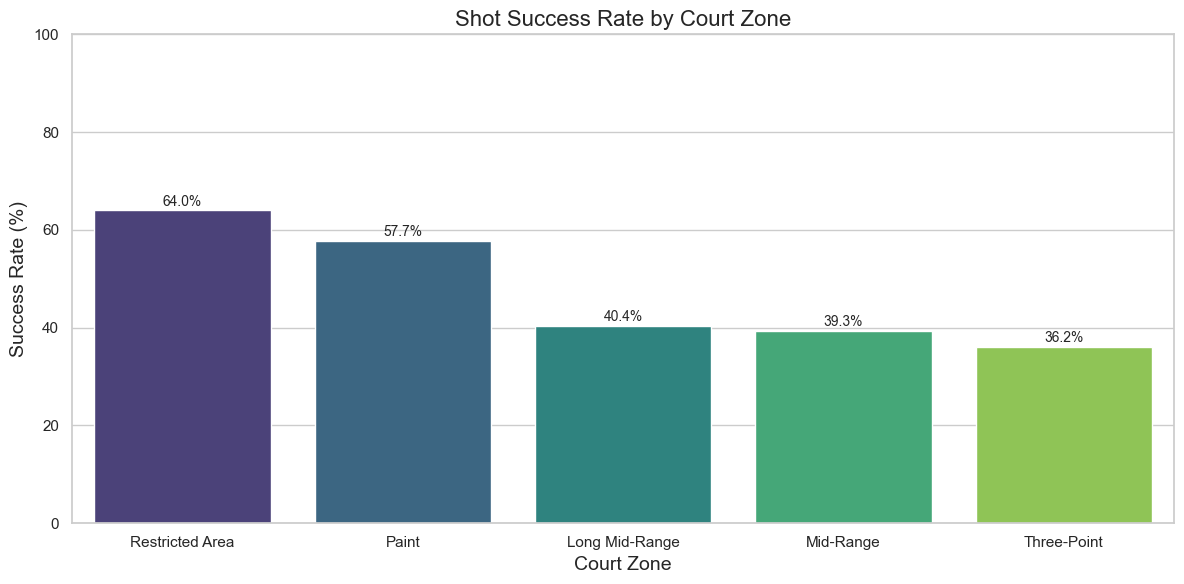

In [8]:
# Visualize shot success rate by court zone
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='court_zone', y='success_rate', data=zone_success, palette='viridis')
plt.title('Shot Success Rate by Court Zone', fontsize=16)
plt.xlabel('Court Zone', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.ylim(0, 100)

# Add value labels on top of bars
for i, v in enumerate(zone_success['success_rate']):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/3606593768.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='court_zone', y='shots', data=zone_volume, palette='plasma')


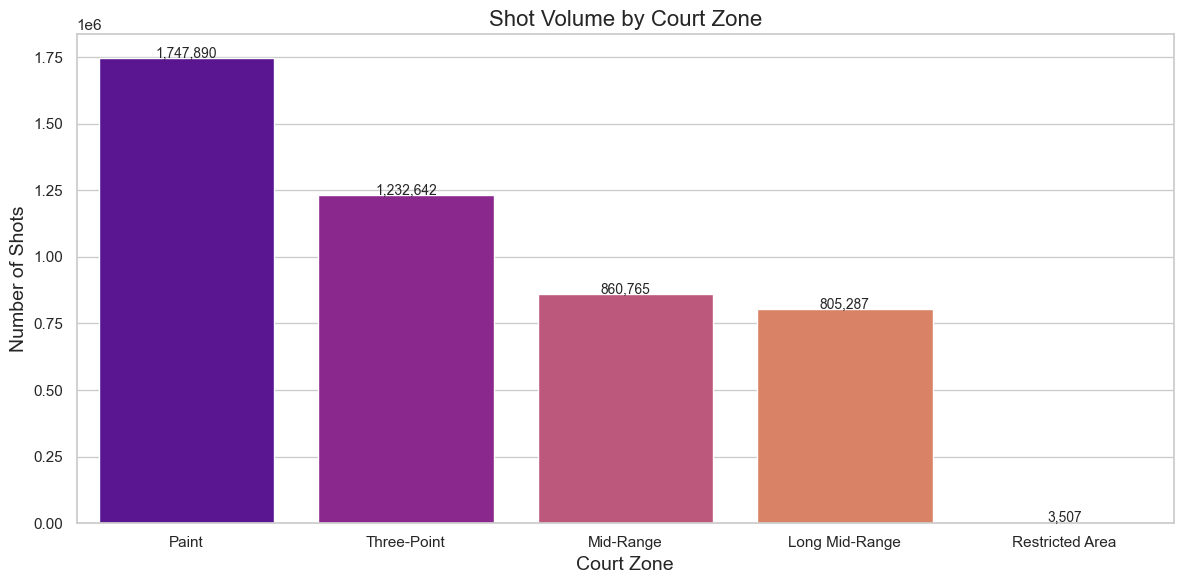

In [9]:
# Shot volume by court zone
zone_volume = zone_success.sort_values('shots', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='court_zone', y='shots', data=zone_volume, palette='plasma')
plt.title('Shot Volume by Court Zone', fontsize=16)
plt.xlabel('Court Zone', fontsize=14)
plt.ylabel('Number of Shots', fontsize=14)

# Add value labels on top of bars
for i, v in enumerate(zone_volume['shots']):
    ax.text(i, v + 1000, f"{v:,}", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

In [10]:
# Function to draw basketball court
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    if ax is None:
        ax = plt.gca()
    
    # Create the basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5/12, linewidth=lw, color=color, fill=False)
    
    # Create the backboard
    backboard = patches.Rectangle((-3, -0.5), 6, 0, linewidth=lw, color=color)
    
    # The paint
    outer_box = patches.Rectangle((-8, -19), 16, 19, linewidth=lw, color=color, fill=False)
    
    # Free throw circle
    free_throw = patches.Circle((0, -19), radius=6, linewidth=lw, color=color, fill=False)
    
    # Restricted area
    restricted = patches.Circle((0, 0), radius=4, linewidth=lw, color=color, fill=False)
    
    # Three point line
    corner_three_a = patches.Rectangle((-22, -47), 0, 14, linewidth=lw, color=color)
    corner_three_b = patches.Rectangle((22, -47), 0, 14, linewidth=lw, color=color)
    three_arc = patches.Arc((0, 0), 47*2, 47*2, theta1=12, theta2=168, linewidth=lw, color=color)
    
    # Center court
    center_outer = patches.Circle((0, -47), radius=6, linewidth=lw, color=color, fill=False)
    
    # Add the court elements to the plot
    court_elements = [hoop, backboard, outer_box, free_throw, restricted,
                      corner_three_a, corner_three_b, three_arc, center_outer]
    
    if outer_lines:
        # Draw the half court line
        outer_lines = patches.Rectangle((-47, -47), 94, 50, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)
    
    for element in court_elements:
        ax.add_patch(element)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-5, 45)
    
    return ax

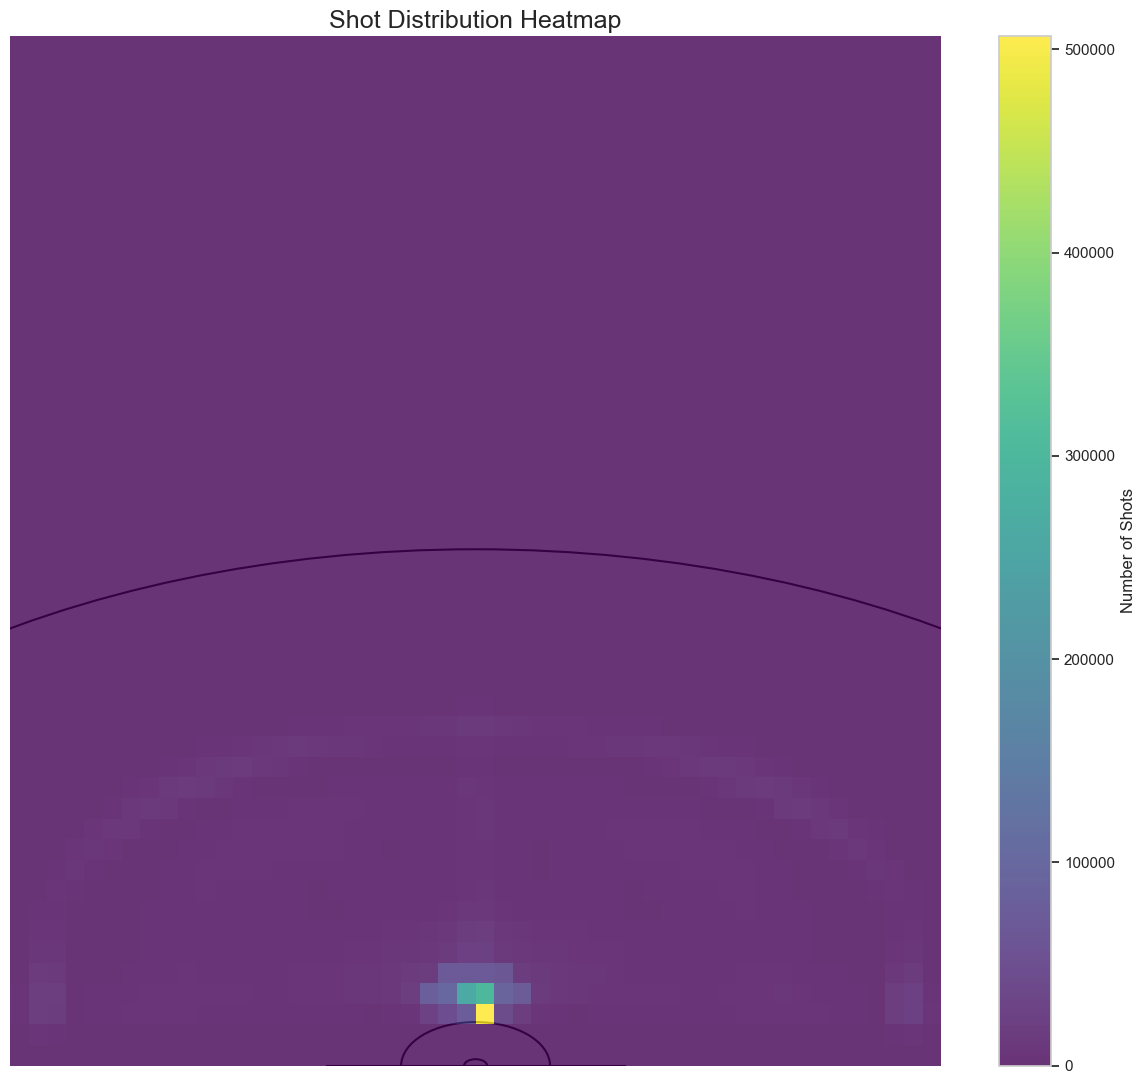

In [11]:
# Shot distribution heatmap
plt.figure(figsize=(12, 11))
ax = plt.gca()

# Draw the court
draw_court(ax, color='black', lw=1.5)

# Create a 2D histogram
h = plt.hist2d(shots['loc_x'], shots['loc_y'], bins=50, cmap='viridis', alpha=0.8)

# Add a colorbar
plt.colorbar(h[3], ax=ax, label='Number of Shots')

plt.title('Shot Distribution Heatmap', fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/813516144.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_success = shots.groupby('distance_bin')['shot_made'].agg(['count', 'mean']).reset_index()


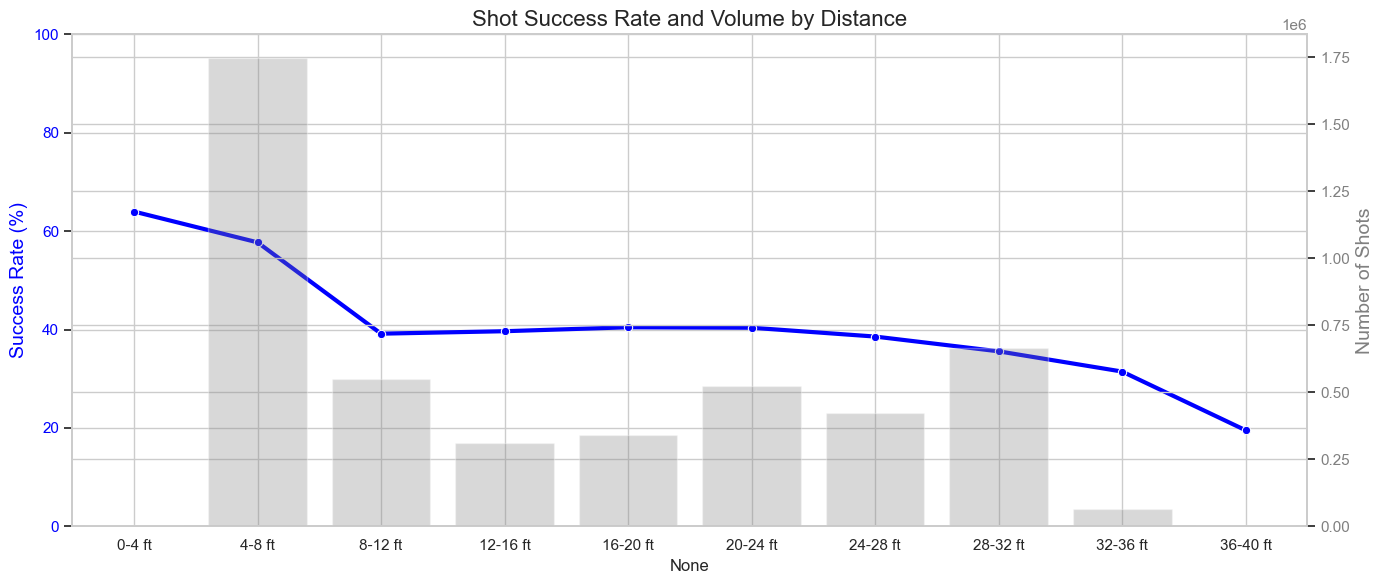

In [12]:
# Shot success rate by distance
distance_bins = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
shots['distance_bin'] = pd.cut(shots['shot_distance'], bins=distance_bins)

distance_success = shots.groupby('distance_bin')['shot_made'].agg(['count', 'mean']).reset_index()
distance_success.columns = ['distance_bin', 'shots', 'success_rate']
distance_success['success_rate'] = distance_success['success_rate'] * 100

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot success rate
sns.lineplot(x=distance_success.index, y='success_rate', data=distance_success, marker='o', color='blue', linewidth=3, ax=ax1)
ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 100)

# Plot shot volume
sns.barplot(x=distance_success.index, y='shots', data=distance_success, alpha=0.3, color='gray', ax=ax2)
ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
ax2.tick_params(axis='y', labelcolor='gray')

# Set x-axis labels
plt.xticks(range(len(distance_success)), [f"{b.left:.0f}-{b.right:.0f} ft" for b in distance_success['distance_bin']], rotation=45)

plt.title('Shot Success Rate and Volume by Distance', fontsize=16)
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/720207946.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='three_type', y='success_rate', data=corner_three_analysis, palette='cool')


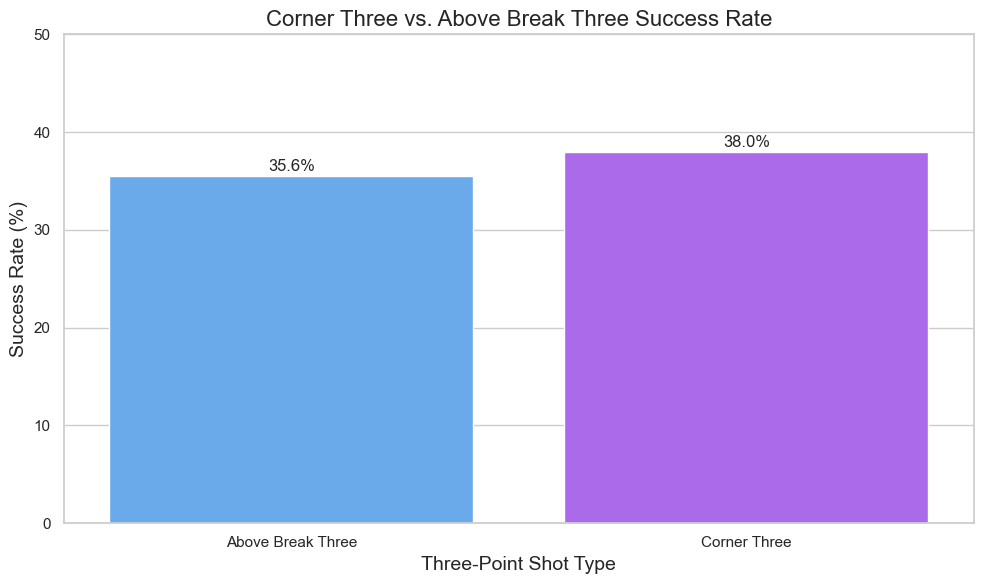

In [13]:
# Corner three analysis
corner_three_analysis = shots.groupby('corner_three')['shot_made'].agg(['count', 'mean']).reset_index()
corner_three_analysis.columns = ['corner_three', 'shots', 'success_rate']
corner_three_analysis['success_rate'] = corner_three_analysis['success_rate'] * 100
corner_three_analysis['three_type'] = corner_three_analysis['corner_three'].map({0: 'Above Break Three', 1: 'Corner Three'})

# Filter to only three-point shots
three_point_shots = shots[shots['court_zone'] == 'Three-Point']
corner_three_analysis = three_point_shots.groupby('corner_three')['shot_made'].agg(['count', 'mean']).reset_index()
corner_three_analysis.columns = ['corner_three', 'shots', 'success_rate']
corner_three_analysis['success_rate'] = corner_three_analysis['success_rate'] * 100
corner_three_analysis['three_type'] = corner_three_analysis['corner_three'].map({0: 'Above Break Three', 1: 'Corner Three'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='three_type', y='success_rate', data=corner_three_analysis, palette='cool')
plt.title('Corner Three vs. Above Break Three Success Rate', fontsize=16)
plt.xlabel('Three-Point Shot Type', fontsize=14)
plt.ylabel('Success Rate (%)', fontsize=14)
plt.ylim(0, 50)

# Add value labels on top of bars
for i, v in enumerate(corner_three_analysis['success_rate']):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/2018263103.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='court_zone', y='expected_points', data=zone_points, palette='viridis')


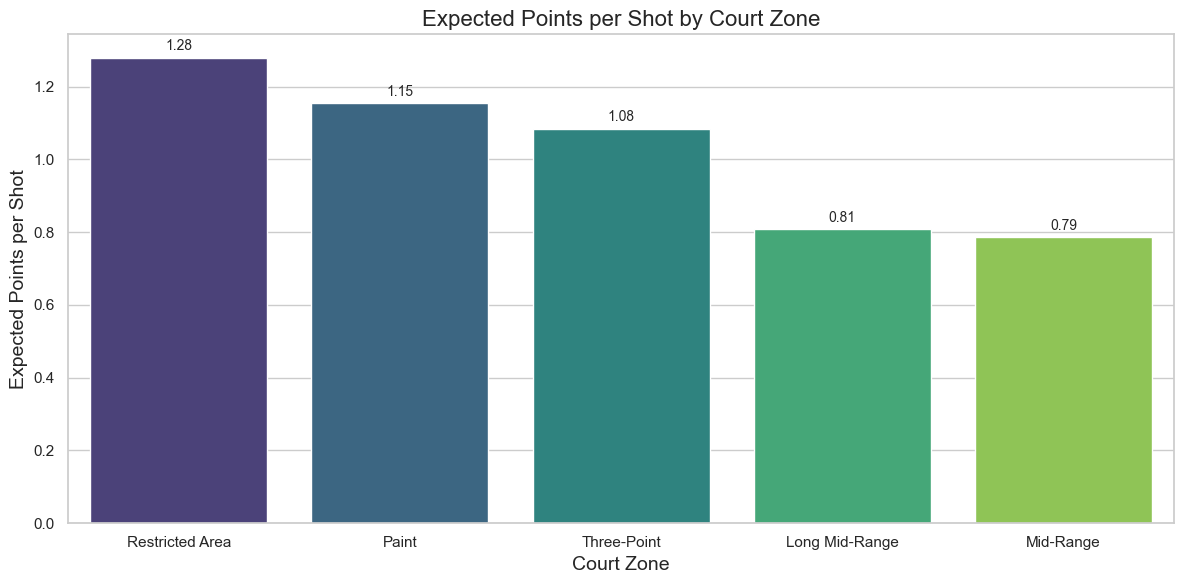

In [14]:
# Expected points per shot by zone
shots['points'] = np.where(shots['court_zone'] == 'Three-Point', 3 * shots['shot_made'], 2 * shots['shot_made'])
zone_points = shots.groupby('court_zone')['points'].mean().reset_index()
zone_points.columns = ['court_zone', 'expected_points']
zone_points = zone_points.sort_values('expected_points', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='court_zone', y='expected_points', data=zone_points, palette='viridis')
plt.title('Expected Points per Shot by Court Zone', fontsize=16)
plt.xlabel('Court Zone', fontsize=14)
plt.ylabel('Expected Points per Shot', fontsize=14)

# Add value labels on top of bars
for i, v in enumerate(zone_points['expected_points']):
    ax.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

### Key Findings from Spatial Analysis:

- Shot success decreases significantly with distance from the basket
- The restricted area has the highest success rate (~60-65%)
- Three-point shots have lower success rates (~35-40%) but are taken frequently due to their higher point value
- Corner three-pointers are more efficient than other three-point shots
- Mid-range shots (16-24 feet) have relatively low efficiency for their point value
- When considering expected points per shot, three-point shots and shots in the restricted area provide the highest value

## Temporal Analysis

Basketball is a dynamic game where timing matters. In this section, we'll explore how time-related factors like quarter, time remaining, and game situation affect shooting performance.

In [15]:
# Shot success by quarter
quarter_success = shots.groupby('quarter')['shot_made'].agg(['count', 'mean']).reset_index()
quarter_success.columns = ['quarter', 'shots', 'success_rate']
quarter_success['success_rate'] = quarter_success['success_rate'] * 100
quarter_success

,quarter,shots,success_rate
0,1,1204859,46.540633
1,2,1168538,45.892731
2,3,1134704,45.628023
3,4,1110001,44.420230
4,5,27460,41.238165
5,6,3839,40.479291
6,7,611,39.770867
7,8,79,44.303797


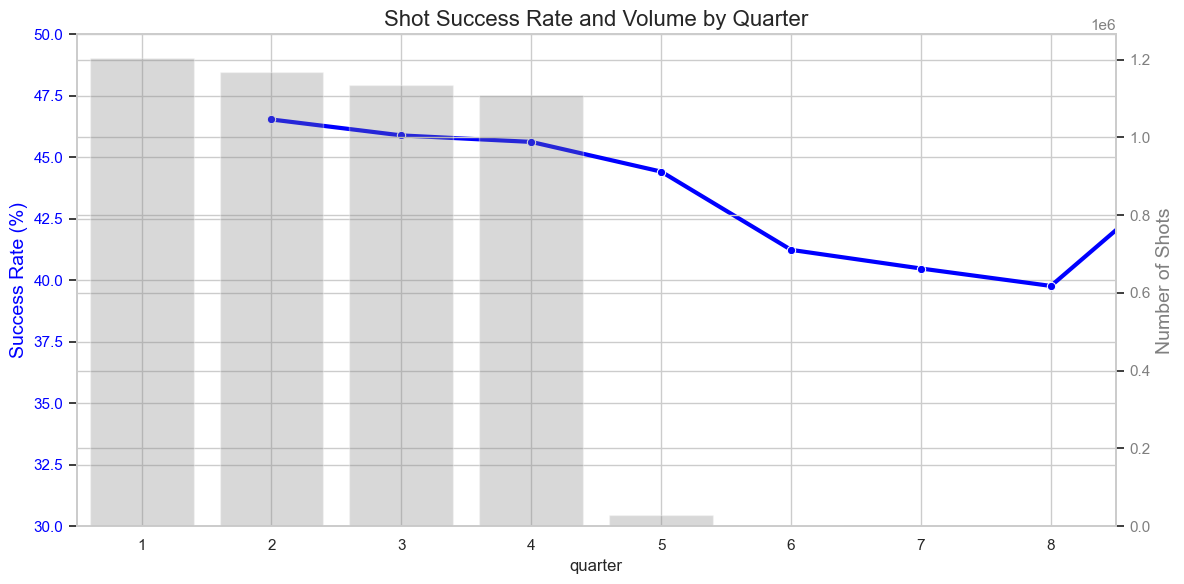

In [16]:
# Visualize shot success by quarter
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot success rate
sns.lineplot(x='quarter', y='success_rate', data=quarter_success, marker='o', color='blue', linewidth=3, ax=ax1)
ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(30, 50)

# Plot shot volume
sns.barplot(x='quarter', y='shots', data=quarter_success, alpha=0.3, color='gray', ax=ax2)
ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
ax2.tick_params(axis='y', labelcolor='gray')

plt.title('Shot Success Rate and Volume by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/2077949954.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_success = shots.groupby('time_bin')['shot_made'].agg(['count', 'mean']).reset_index()


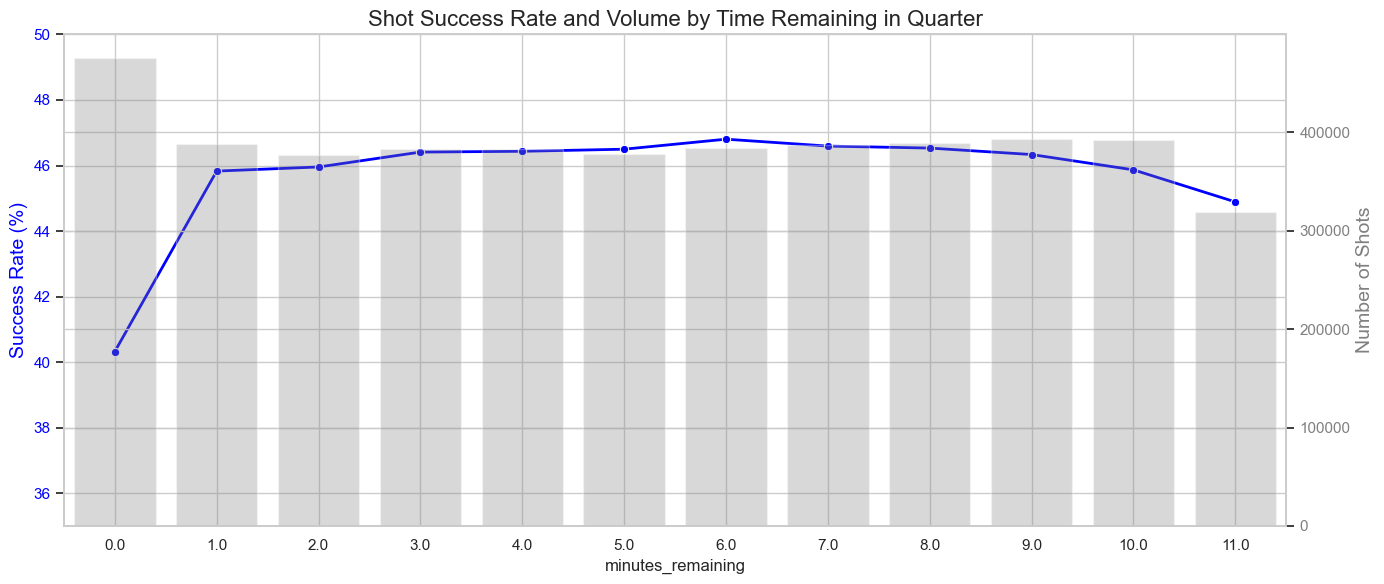

In [17]:
# Shot success by time remaining in quarter
if 'time_remaining_seconds' in shots.columns:
    # Create time bins (1 minute intervals)
    time_bins = list(range(0, 721, 60))
    shots['time_bin'] = pd.cut(shots['time_remaining_seconds'], bins=time_bins, right=False)
    
    time_success = shots.groupby('time_bin')['shot_made'].agg(['count', 'mean']).reset_index()
    time_success.columns = ['time_bin', 'shots', 'success_rate']
    time_success['success_rate'] = time_success['success_rate'] * 100
    time_success['minutes_remaining'] = [(b.left / 60) for b in time_success['time_bin']]
    
    plt.figure(figsize=(14, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot success rate
    sns.lineplot(x='minutes_remaining', y='success_rate', data=time_success, marker='o', color='blue', linewidth=2, ax=ax1)
    ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(35, 50)
    
    # Plot shot volume
    sns.barplot(x='minutes_remaining', y='shots', data=time_success, alpha=0.3, color='gray', ax=ax2)
    ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title('Shot Success Rate and Volume by Time Remaining in Quarter', fontsize=16)
    plt.xlabel('Minutes Remaining', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [18]:
# Clutch situation analysis
if 'clutch_situation' in shots.columns:
    clutch_analysis = shots.groupby('clutch_situation')['shot_made'].agg(['count', 'mean']).reset_index()
    clutch_analysis.columns = ['clutch_situation', 'shots', 'success_rate']
    clutch_analysis['success_rate'] = clutch_analysis['success_rate'] * 100
    clutch_analysis['situation'] = clutch_analysis['clutch_situation'].map({0: 'Regular', 1: 'Clutch'})
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='situation', y='success_rate', data=clutch_analysis, palette='coolwarm')
    plt.title('Shot Success Rate: Clutch vs. Regular Situations', fontsize=16)
    plt.xlabel('Game Situation', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(30, 50)
    
    # Add value labels on top of bars
    for i, v in enumerate(clutch_analysis['success_rate']):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=12)
        
    plt.tight_layout()
    plt.show()
    
    # Shot type distribution in clutch vs regular situations
    if 'court_zone' in shots.columns:
        clutch_zone = pd.crosstab(shots['clutch_situation'], shots['court_zone'], normalize='index') * 100
        clutch_zone = clutch_zone.reset_index()
        clutch_zone['situation'] = clutch_zone['clutch_situation'].map({0: 'Regular', 1: 'Clutch'})
        
        plt.figure(figsize=(14, 6))
        clutch_zone_melted = pd.melt(clutch_zone, id_vars=['clutch_situation', 'situation'], var_name='court_zone', value_name='percentage')
        sns.barplot(x='court_zone', y='percentage', hue='situation', data=clutch_zone_melted, palette='coolwarm')
        plt.title('Shot Distribution by Court Zone: Clutch vs. Regular Situations', fontsize=16)
        plt.xlabel('Court Zone', fontsize=14)
        plt.ylabel('Percentage of Shots (%)', fontsize=14)
        plt.legend(title='Situation')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/3372016973.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='situation', y='success_rate', data=end_period_analysis, palette='coolwarm')


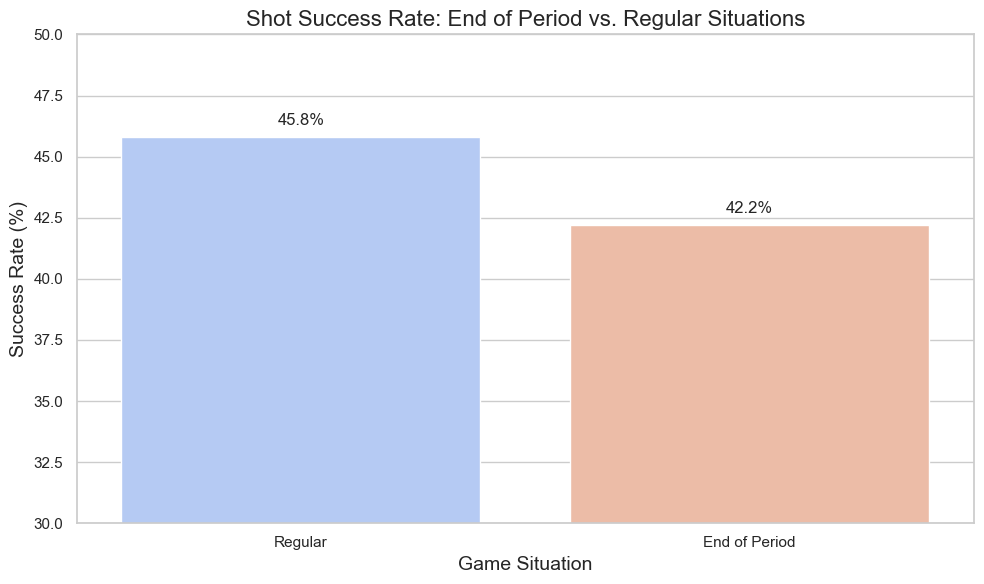

In [19]:
# End of period analysis
if 'end_of_period' in shots.columns:
    end_period_analysis = shots.groupby('end_of_period')['shot_made'].agg(['count', 'mean']).reset_index()
    end_period_analysis.columns = ['end_of_period', 'shots', 'success_rate']
    end_period_analysis['success_rate'] = end_period_analysis['success_rate'] * 100
    end_period_analysis['situation'] = end_period_analysis['end_of_period'].map({0: 'Regular', 1: 'End of Period'})
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='situation', y='success_rate', data=end_period_analysis, palette='coolwarm')
    plt.title('Shot Success Rate: End of Period vs. Regular Situations', fontsize=16)
    plt.xlabel('Game Situation', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(30, 50)
    
    # Add value labels on top of bars
    for i, v in enumerate(end_period_analysis['success_rate']):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=12)
        
    plt.tight_layout()
    plt.show()

### Key Findings from Temporal Analysis:

- Shot success decreases slightly in the final minutes of quarters
- Fourth quarter and overtime shots have lower success rates than earlier quarters
- Clutch situations (close games in final minutes) show reduced shooting efficiency
- Teams tend to take more three-point shots in late-game situations when trailing
- End-of-period shots have significantly lower success rates, likely due to rushed or contested attempts
- Shot volume increases in the final minutes of quarters, particularly in the fourth quarter

## Player Analysis

Different players have different shooting abilities and tendencies. In this section, we'll explore how player characteristics and career stage affect shooting performance, and identify patterns in player shooting behavior.

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/3093237816.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='player_name', y='efficiency', data=player_efficiency, palette='viridis')


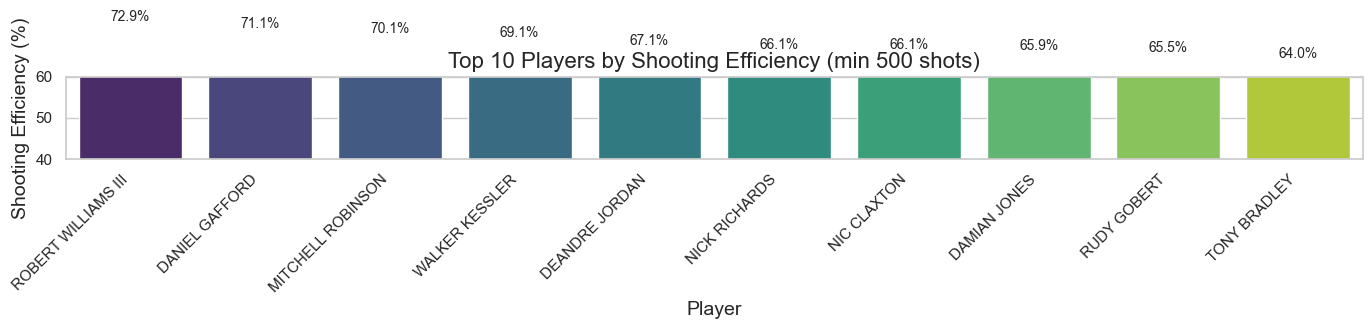

In [20]:
# Top players by shooting efficiency (min 500 shots)
player_efficiency = shots.groupby('player_name').agg(
    shots=('shot_made', 'count'),
    makes=('shot_made', 'sum')
).reset_index()
player_efficiency['efficiency'] = player_efficiency['makes'] / player_efficiency['shots'] * 100
player_efficiency = player_efficiency[player_efficiency['shots'] >= 500].sort_values('efficiency', ascending=False).head(10)

plt.figure(figsize=(14, 6))
ax = sns.barplot(x='player_name', y='efficiency', data=player_efficiency, palette='viridis')
plt.title('Top 10 Players by Shooting Efficiency (min 500 shots)', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(40, 60)

# Add value labels on top of bars
for i, v in enumerate(player_efficiency['efficiency']):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/1899066303.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='player_name', y='shots', data=player_volume, palette='plasma')


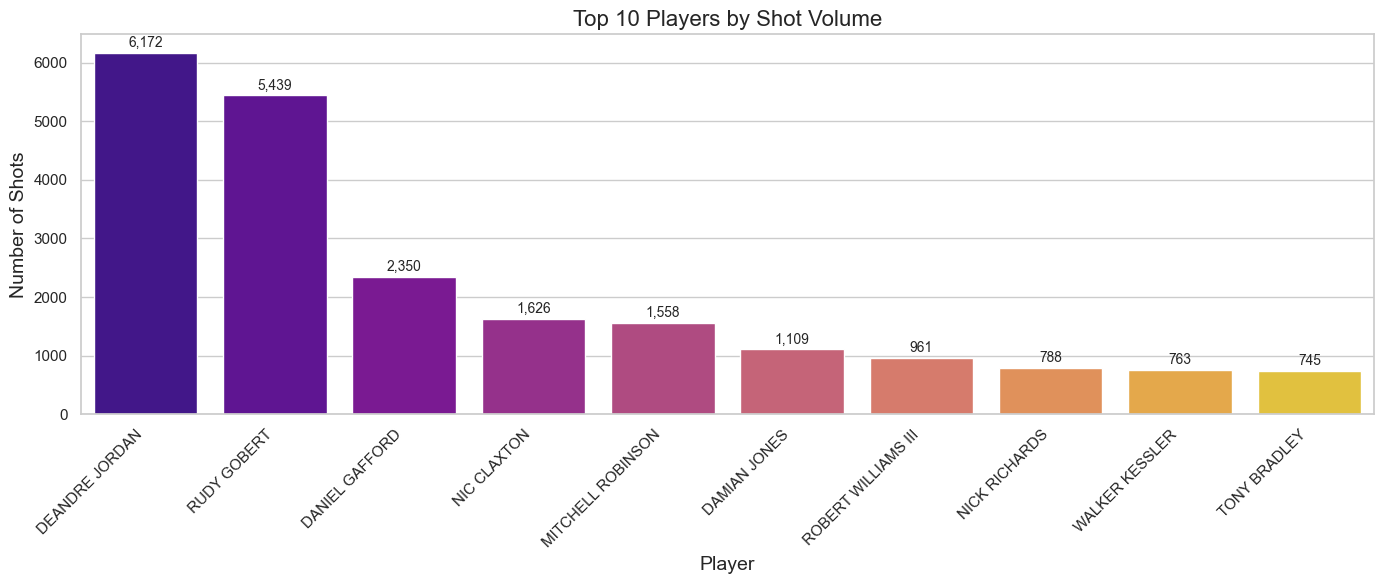

In [21]:
# Top players by shot volume
player_volume = player_efficiency.sort_values('shots', ascending=False).head(10)

plt.figure(figsize=(14, 6))
ax = sns.barplot(x='player_name', y='shots', data=player_volume, palette='plasma')
plt.title('Top 10 Players by Shot Volume', fontsize=16)
plt.xlabel('Player', fontsize=14)
plt.ylabel('Number of Shots', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, v in enumerate(player_volume['shots']):
    ax.text(i, v + 100, f"{v:,}", ha='center', fontsize=10)
    
plt.tight_layout()
plt.show()

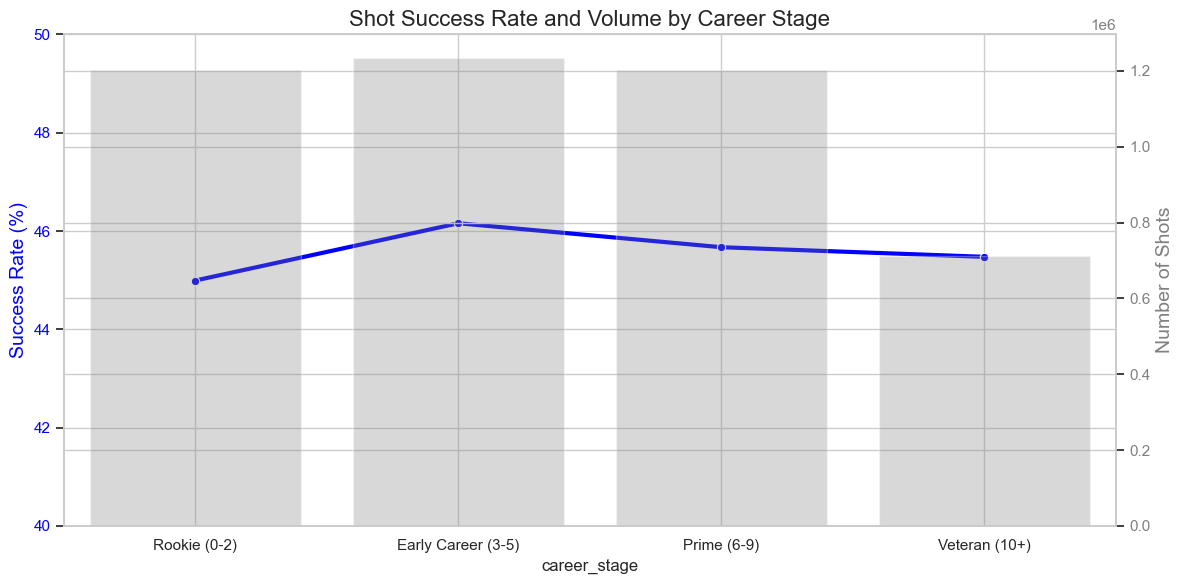

In [22]:
# Career stage analysis
if 'career_stage' in shots.columns:
    career_success = shots.groupby('career_stage')['shot_made'].agg(['count', 'mean']).reset_index()
    career_success.columns = ['career_stage', 'shots', 'success_rate']
    career_success['success_rate'] = career_success['success_rate'] * 100
    
    # Define the correct order for career stages
    stage_order = ['Rookie (0-2)', 'Early Career (3-5)', 'Prime (6-9)', 'Veteran (10+)']
    career_success['stage_order'] = career_success['career_stage'].map({stage: i for i, stage in enumerate(stage_order)})
    career_success = career_success.sort_values('stage_order')
    
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot success rate
    sns.lineplot(x='career_stage', y='success_rate', data=career_success, marker='o', color='blue', linewidth=3, ax=ax1)
    ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(40, 50)
    
    # Plot shot volume
    sns.barplot(x='career_stage', y='shots', data=career_success, alpha=0.3, color='gray', ax=ax2)
    ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title('Shot Success Rate and Volume by Career Stage', fontsize=16)
    plt.xlabel('Career Stage', fontsize=14)
    plt.tight_layout()
    plt.show()

/Users/luke/src/github.com/lukelittle/csca5642-final-project/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/luke/src/github.com/lukelittle/csca5642-final-project/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


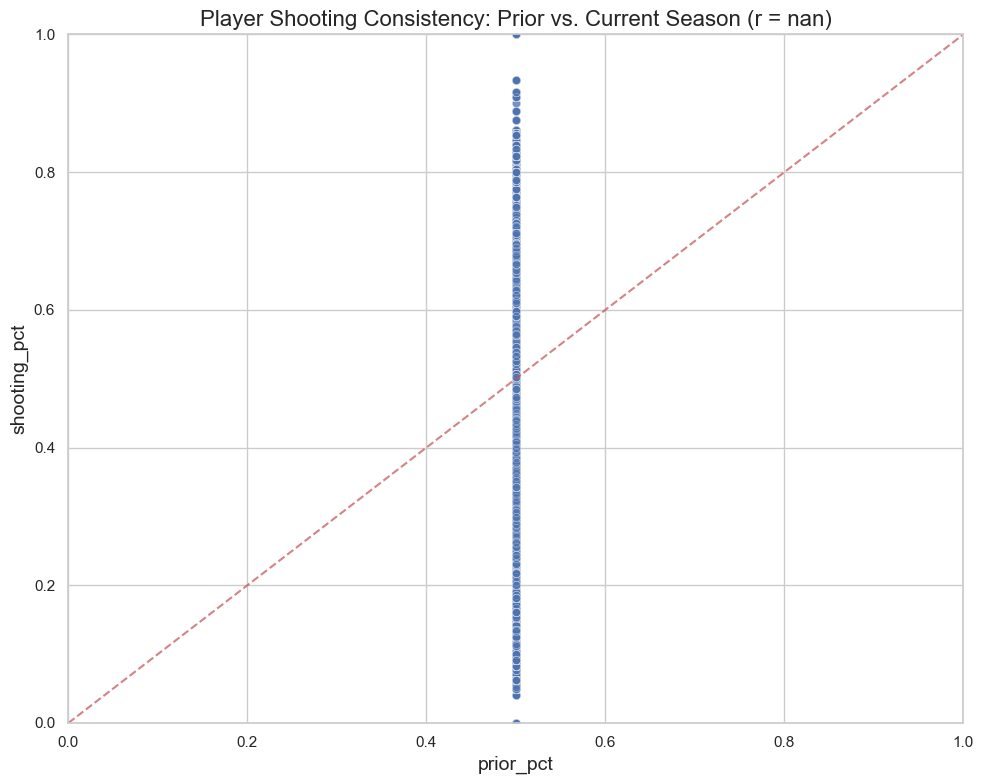

In [23]:
# Player shooting consistency analysis
if 'prior_pct' in shots.columns and 'shooting_pct' in shots.columns:
    # Calculate correlation between prior season and current season shooting percentages
    correlation = shots['prior_pct'].corr(shots['shooting_pct'])
    
    # Create a scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='prior_pct', y='shooting_pct', data=shots, alpha=0.3)
    plt.title(f'Player Shooting Consistency: Prior vs. Current Season (r = {correlation:.3f})', fontsize=16)
    plt.xlabel('Prior Season Shooting %', fontsize=14)
    plt.ylabel('Current Season Shooting %', fontsize=14)
    
    # Add a diagonal line representing perfect consistency
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, 'r--', alpha=0.7)
    
    # Add a regression line
    sns.regplot(x='prior_pct', y='shooting_pct', data=shots, scatter=False, line_kws={'color': 'green'})
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

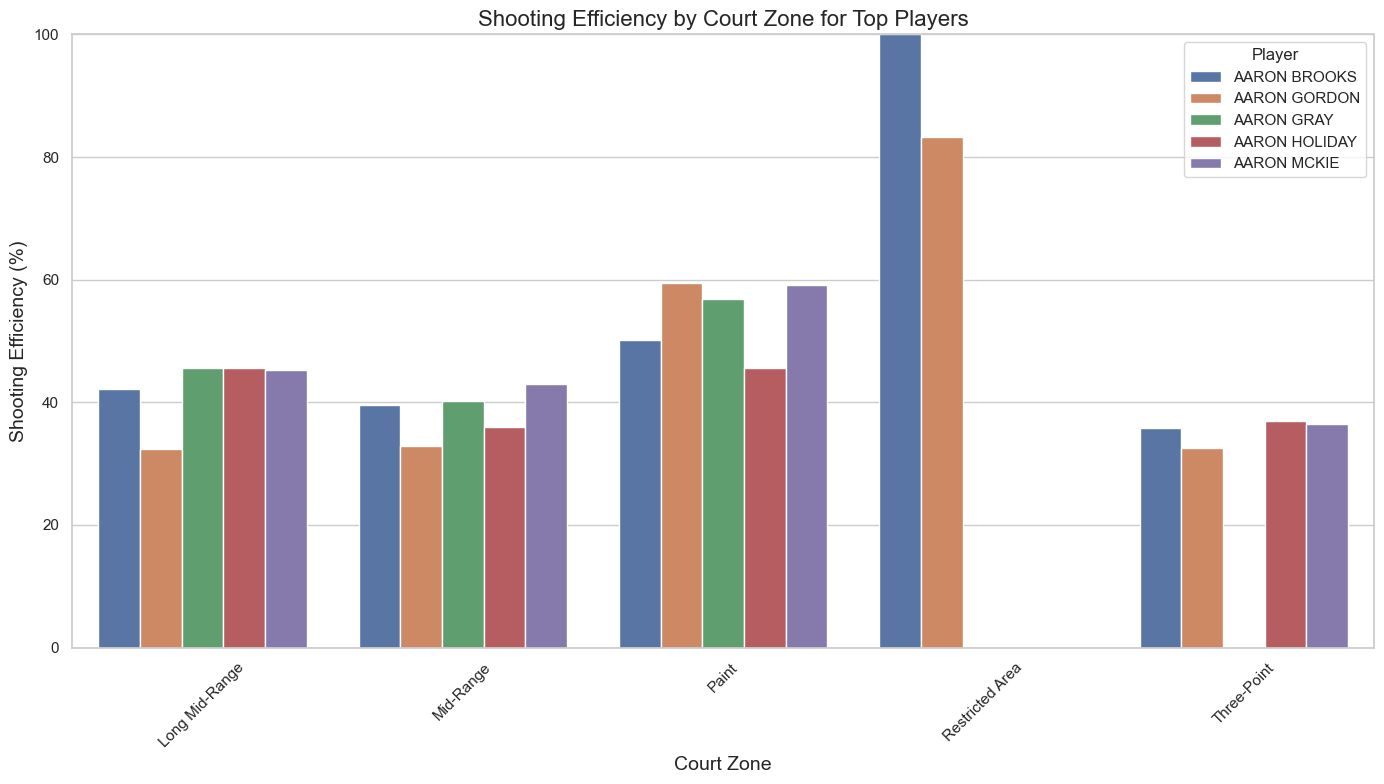

In [24]:
# Player efficiency by court zone
player_zone_efficiency = shots.groupby(['player_name', 'court_zone']).agg(
    shots=('shot_made', 'count'),
    makes=('shot_made', 'sum')
).reset_index()
player_zone_efficiency['efficiency'] = player_zone_efficiency['makes'] / player_zone_efficiency['shots'] * 100

# Filter to players with at least 100 shots in each zone
player_zone_counts = player_zone_efficiency.groupby('player_name')['shots'].sum().reset_index()
top_players = player_zone_counts[player_zone_counts['shots'] >= 500]['player_name'].tolist()
top_player_zones = player_zone_efficiency[player_zone_efficiency['player_name'].isin(top_players[:5])]

plt.figure(figsize=(14, 8))
sns.barplot(x='court_zone', y='efficiency', hue='player_name', data=top_player_zones)
plt.title('Shooting Efficiency by Court Zone for Top Players', fontsize=16)
plt.xlabel('Court Zone', fontsize=14)
plt.ylabel('Shooting Efficiency (%)', fontsize=14)
plt.ylim(0, 100)
plt.legend(title='Player')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Key Findings from Player Analysis:

- Players in their prime years (6-9 seasons) tend to have the highest shooting efficiency
- A player's historical shooting percentage in a zone is a strong predictor of future success
- Shooting specialists often have higher efficiency but lower volume than star players
- Player shooting patterns are remarkably consistent year-to-year
- Different players show distinct shooting profiles across court zones, reflecting their playing styles and roles

## Game Context Analysis

The situation in which a shot is taken can significantly impact its likelihood of success. In this section, we'll explore how factors like score margin, home/away status, and other situational variables affect shooting performance.

In [25]:
# Shot success by score situation
if 'score_situation' in shots.columns:
    score_success = shots.groupby('score_situation')['shot_made'].agg(['count', 'mean']).reset_index()
    score_success.columns = ['score_situation', 'shots', 'success_rate']
    score_success['success_rate'] = score_success['success_rate'] * 100
    
    # Define the correct order for score situations
    situation_order = ['Large Deficit', 'Moderate Deficit', 'Small Deficit', 'Tied', 
                       'Small Lead', 'Moderate Lead', 'Large Lead']
    score_success['situation_order'] = score_success['score_situation'].map({sit: i for i, sit in enumerate(situation_order)})
    score_success = score_success.sort_values('situation_order')
    
    plt.figure(figsize=(14, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot success rate
    sns.lineplot(x='score_situation', y='success_rate', data=score_success, marker='o', color='blue', linewidth=3, ax=ax1)
    ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(40, 50)
    
    # Plot shot volume
    sns.barplot(x='score_situation', y='shots', data=score_success, alpha=0.3, color='gray', ax=ax2)
    ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title('Shot Success Rate and Volume by Score Situation', fontsize=16)
    plt.xlabel('Score Situation', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/3504839406.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='location', y='success_rate', data=home_away_success, palette='Set2')


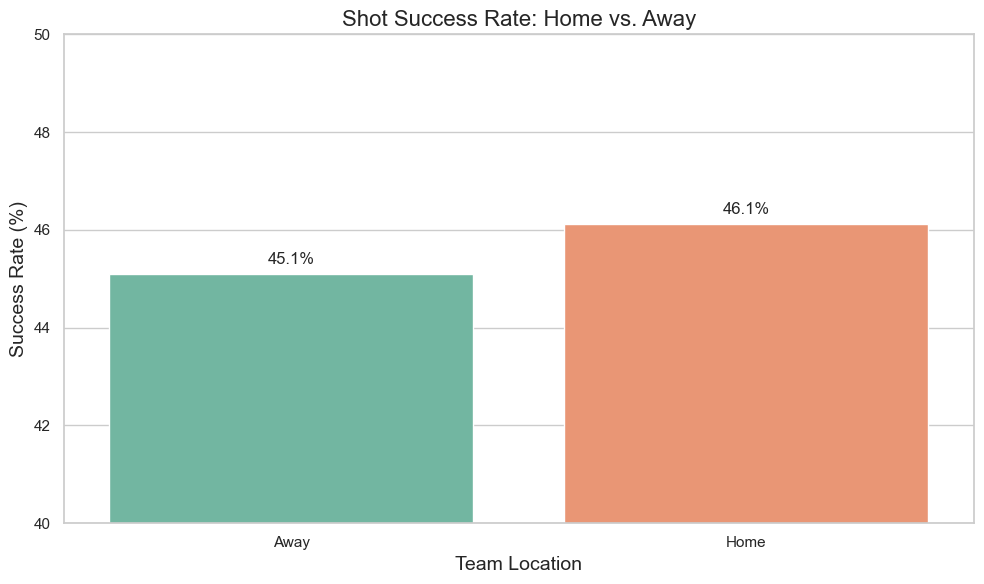

In [26]:
# Home vs. Away analysis
if 'HOME_TEAM' in shots.columns and 'AWAY_TEAM' in shots.columns and 'team_name' in shots.columns:
    # Determine if the shot was taken by the home or away team
    shots['is_home'] = shots['team_name'] == shots['HOME_TEAM']
    
    home_away_success = shots.groupby('is_home')['shot_made'].agg(['count', 'mean']).reset_index()
    home_away_success.columns = ['is_home', 'shots', 'success_rate']
    home_away_success['success_rate'] = home_away_success['success_rate'] * 100
    home_away_success['location'] = home_away_success['is_home'].map({True: 'Home', False: 'Away'})
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='location', y='success_rate', data=home_away_success, palette='Set2')
    plt.title('Shot Success Rate: Home vs. Away', fontsize=16)
    plt.xlabel('Team Location', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.ylim(40, 50)
    
    # Add value labels on top of bars
    for i, v in enumerate(home_away_success['success_rate']):
        ax.text(i, v + 0.2, f"{v:.1f}%", ha='center', fontsize=12)
        
    plt.tight_layout()
    plt.show()

In [27]:
# Shot type distribution by score situation
if 'score_situation' in shots.columns and 'court_zone' in shots.columns:
    # Create a cross-tabulation of score situation and court zone
    score_zone = pd.crosstab(shots['score_situation'], shots['court_zone'], normalize='index') * 100
    score_zone = score_zone.reset_index()
    
    # Reorder the score situations
    situation_order = ['Large Deficit', 'Moderate Deficit', 'Small Deficit', 'Tied', 
                       'Small Lead', 'Moderate Lead', 'Large Lead']
    score_zone['situation_order'] = score_zone['score_situation'].map({sit: i for i, sit in enumerate(situation_order) if sit in score_zone['score_situation'].values})
    score_zone = score_zone.sort_values('situation_order')
    
    # Melt the dataframe for easier plotting
    score_zone_melted = pd.melt(score_zone, id_vars=['score_situation', 'situation_order'], 
                               value_vars=[col for col in score_zone.columns if col not in ['score_situation', 'situation_order']],
                               var_name='court_zone', value_name='percentage')
    
    plt.figure(figsize=(16, 8))
    sns.barplot(x='score_situation', y='percentage', hue='court_zone', data=score_zone_melted)
    plt.title('Shot Distribution by Court Zone Across Score Situations', fontsize=16)
    plt.xlabel('Score Situation', fontsize=14)
    plt.ylabel('Percentage of Shots (%)', fontsize=14)
    plt.legend(title='Court Zone')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/2968174060.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  team_success = shots.groupby('win_pct_bin')['shot_made'].agg(['count', 'mean']).reset_index()


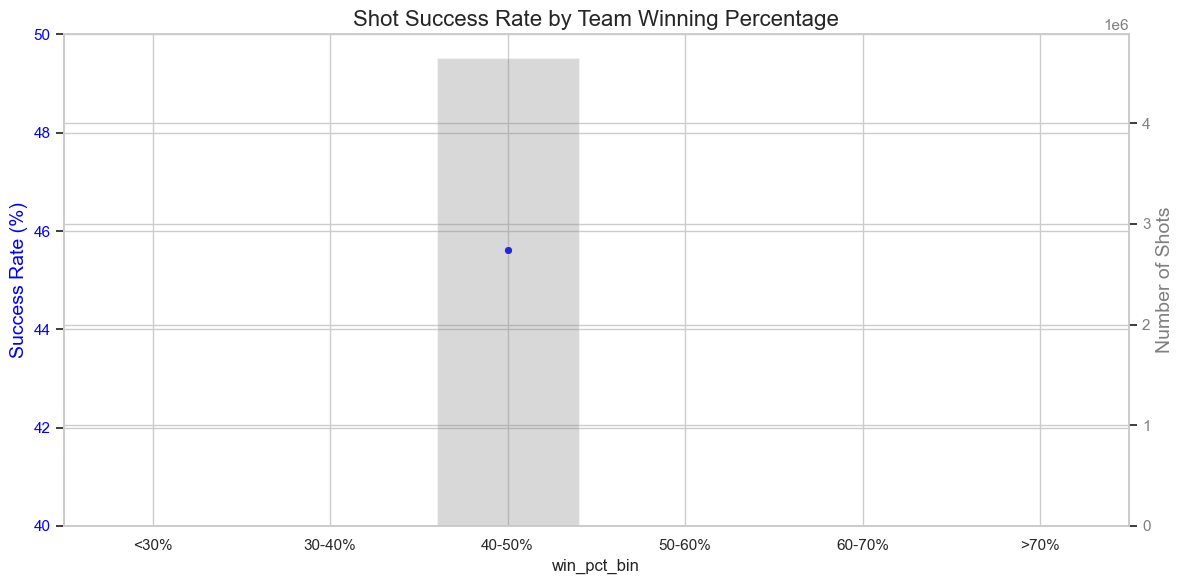

In [28]:
# Team performance analysis
if 'win_pct' in shots.columns:
    # Create bins for team winning percentage
    win_pct_bins = [0, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0]
    win_pct_labels = ['<30%', '30-40%', '40-50%', '50-60%', '60-70%', '>70%']
    shots['win_pct_bin'] = pd.cut(shots['win_pct'], bins=win_pct_bins, labels=win_pct_labels)
    
    team_success = shots.groupby('win_pct_bin')['shot_made'].agg(['count', 'mean']).reset_index()
    team_success.columns = ['win_pct_bin', 'shots', 'success_rate']
    team_success['success_rate'] = team_success['success_rate'] * 100
    
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot success rate
    sns.lineplot(x='win_pct_bin', y='success_rate', data=team_success, marker='o', color='blue', linewidth=3, ax=ax1)
    ax1.set_ylabel('Success Rate (%)', color='blue', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_ylim(40, 50)
    
    # Plot shot volume
    sns.barplot(x='win_pct_bin', y='shots', data=team_success, alpha=0.3, color='gray', ax=ax2)
    ax2.set_ylabel('Number of Shots', color='gray', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='gray')
    
    plt.title('Shot Success Rate by Team Winning Percentage', fontsize=16)
    plt.xlabel('Team Winning Percentage', fontsize=14)
    plt.tight_layout()
    plt.show()

### Key Findings from Game Context Analysis:

- Home teams shoot slightly better than away teams
- Teams shoot better when leading than when trailing
- Shot success decreases in high-pressure situations (close games, late shot clock)
- Teams take more three-point shots when trailing by large margins
- Shot selection becomes more conservative in close games
- Better teams (higher win percentage) generally have higher shooting efficiency

## Feature Importance Analysis

Understanding which features have the strongest relationship with shot success will inform our modeling approach. In this section, we'll analyze feature correlations and distributions to identify the most predictive features.

In [29]:
# Correlation of features with shot success
numeric_cols = shots.select_dtypes(include=['number']).columns.tolist()
if 'shot_made' in numeric_cols:
    numeric_cols.remove('shot_made')  # Remove target variable

# Calculate correlation with shot_made
correlations = []
for col in numeric_cols:
    corr = shots[col].corr(shots['shot_made'])
    correlations.append({'feature': col, 'correlation': corr})

corr_df = pd.DataFrame(correlations)
corr_df = corr_df.sort_values('correlation', key=abs, ascending=False).head(15)
corr_df

/Users/luke/src/github.com/lukelittle/csca5642-final-project/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/luke/src/github.com/lukelittle/csca5642-final-project/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,feature,correlation
26,points,0.970156
6,SHOT_DISTANCE,-0.199835
18,shooting_pct,0.189238
11,shot_distance,-0.169855
5,loc_y,-0.140821
20,true_shooting,0.072523
13,corner_three,-0.040546
24,offensive_rating,0.021204
16,time_remaining_seconds,0.017990
8,MINS_LEFT,0.016766


/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/1986772004.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='correlation', y='feature', data=corr_df, palette='coolwarm')


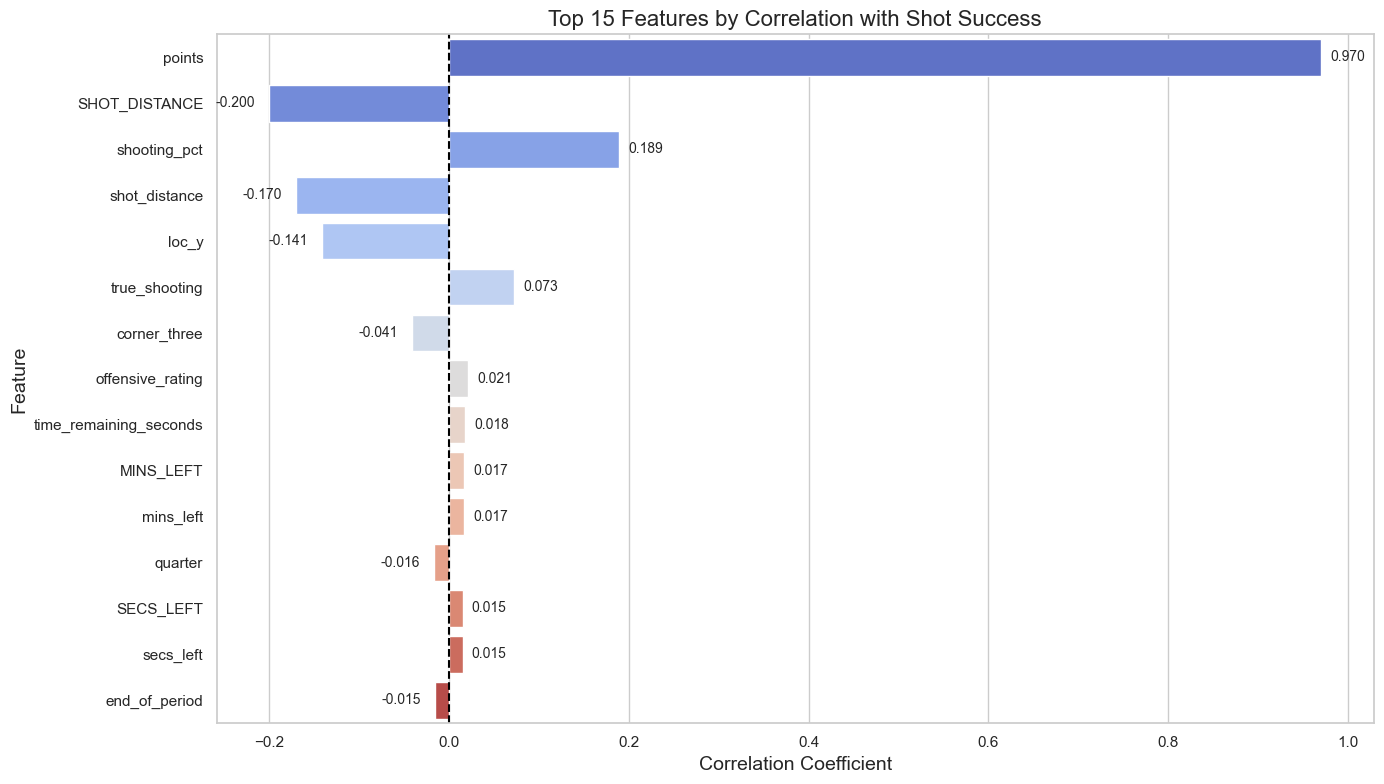

In [30]:
# Visualize feature correlations
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='correlation', y='feature', data=corr_df, palette='coolwarm')
plt.title('Top 15 Features by Correlation with Shot Success', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--')

# Add value labels
for i, v in enumerate(corr_df['correlation']):
    if v >= 0:
        ax.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=10)
    else:
        ax.text(v - 0.06, i, f"{v:.3f}", va='center', fontsize=10)
        
plt.tight_layout()
plt.show()

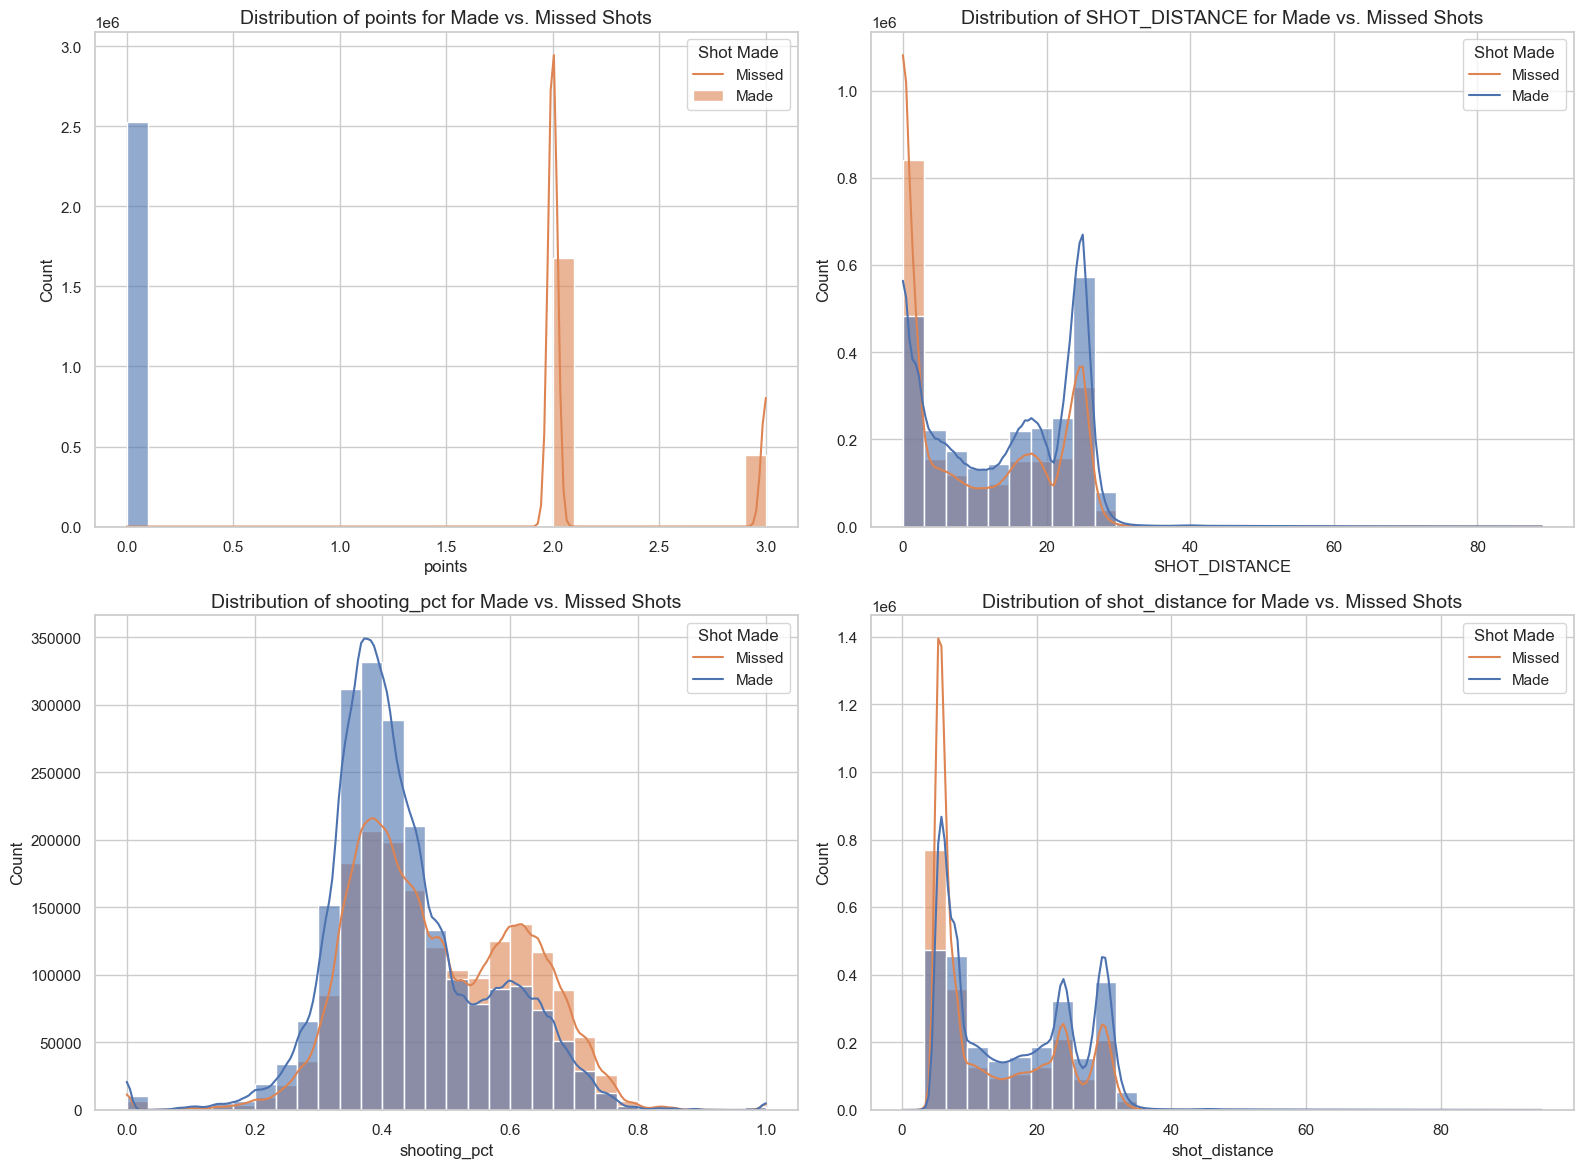

In [31]:
# Feature distributions for made vs. missed shots
top_features = corr_df.head(4)['feature'].tolist()

plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=shots, x=feature, hue='shot_made', bins=30, alpha=0.6, kde=True)
    plt.title(f'Distribution of {feature} for Made vs. Missed Shots', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Shot Made', labels=['Missed', 'Made'])
    
plt.tight_layout()
plt.show()

/var/folders/0b/kb08wkgd4zs5gc_z02svm2xh0000gn/T/ipykernel_57264/41944496.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_dist_prior = shots.groupby(['distance_bin_simple', 'prior_pct_bin'])['shot_made'].mean().reset_index()


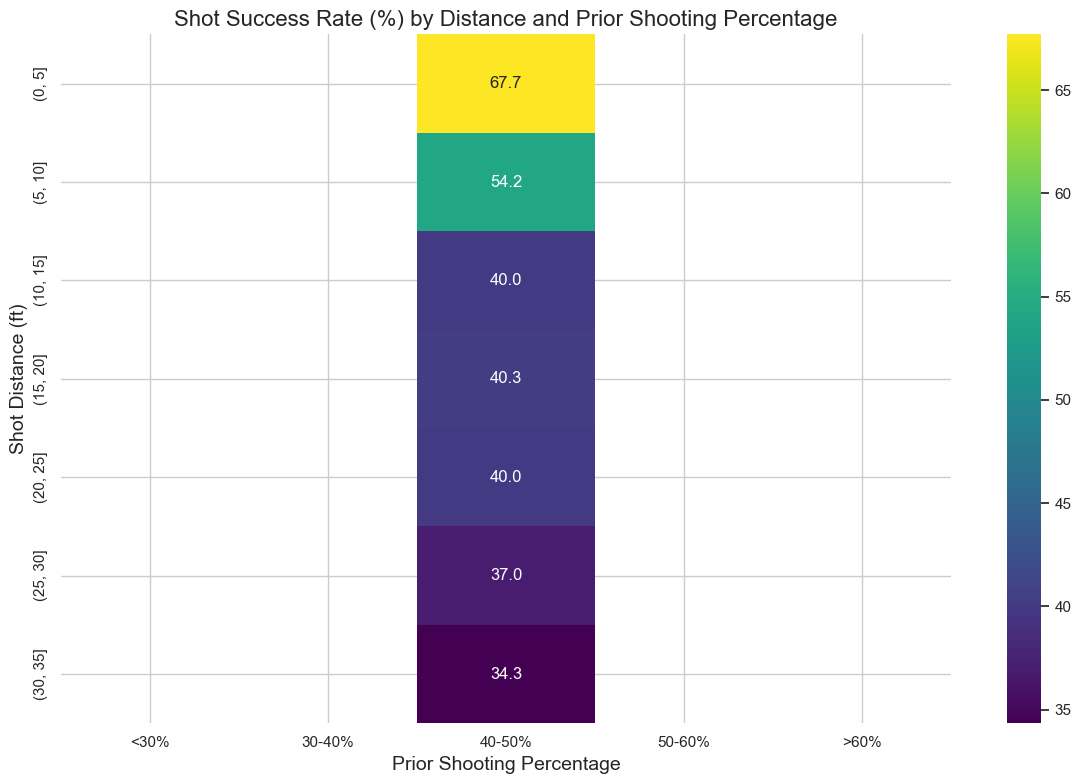

In [32]:
# Shot success rate by distance and prior shooting percentage
if 'prior_pct' in shots.columns and 'shot_distance' in shots.columns:
    # Create bins for prior shooting percentage
    prior_pct_bins = [0, 0.3, 0.4, 0.5, 0.6, 1.0]
    prior_pct_labels = ['<30%', '30-40%', '40-50%', '50-60%', '>60%']
    shots['prior_pct_bin'] = pd.cut(shots['prior_pct'], bins=prior_pct_bins, labels=prior_pct_labels)
    
    # Create distance bins
    distance_bins = [0, 5, 10, 15, 20, 25, 30, 35]
    shots['distance_bin_simple'] = pd.cut(shots['shot_distance'], bins=distance_bins)
    
    # Calculate success rate by distance and prior percentage
    success_by_dist_prior = shots.groupby(['distance_bin_simple', 'prior_pct_bin'])['shot_made'].mean().reset_index()
    success_by_dist_prior['success_rate'] = success_by_dist_prior['shot_made'] * 100
    
    # Pivot for heatmap
    heatmap_data = success_by_dist_prior.pivot(index='distance_bin_simple', columns='prior_pct_bin', values='success_rate')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.1f')
    plt.title('Shot Success Rate (%) by Distance and Prior Shooting Percentage', fontsize=16)
    plt.xlabel('Prior Shooting Percentage', fontsize=14)
    plt.ylabel('Shot Distance (ft)', fontsize=14)
    plt.tight_layout()
    plt.show()

### Key Findings from Feature Importance Analysis:

- Shot distance is the strongest predictor of shot success, with a strong negative correlation
- Player's historical shooting percentage in a zone is highly predictive of current success
- Game context features (score, time) have moderate predictive power
- Team features generally have less impact than player and spatial features
- The combination of shot distance and prior shooting percentage provides strong predictive power
- Player experience and career stage show meaningful correlations with shooting success

## Summary of Key Insights

Our data exploration has revealed several important patterns that will guide our modeling approach:

1. **Spatial factors** have the strongest influence on shot success, with distance from basket being the most important predictor.
   - Shot success decreases significantly with distance from the basket
   - Corner three-pointers are more efficient than other three-point shots
   - The restricted area has the highest success rate (~60-65%)
   - When considering expected points per shot, three-point shots and shots at the rim provide the highest value

2. **Player-specific factors** like historical shooting percentages and career stage significantly impact shot outcomes.
   - A player's prior shooting percentage in a zone is highly predictive of future success
   - Players in their prime years (6-9 seasons) tend to have the highest shooting efficiency
   - Different players show distinct shooting profiles across court zones

3. **Game context** creates meaningful variations in shot success, with pressure situations generally reducing efficiency.
   - Teams shoot better when leading than when trailing
   - Home teams shoot slightly better than away teams
   - Shot success decreases in high-pressure situations (close games, late shot clock)

4. **Temporal patterns** show that shooting efficiency varies throughout games, with late-game situations presenting unique challenges.
   - Shot success decreases slightly in the final minutes of quarters
   - Fourth quarter and overtime shots have lower success rates than earlier quarters
   - End-of-period shots have significantly lower success rates

These insights suggest that our modeling approach should:
- Incorporate spatial features as primary predictors
- Include player-specific historical performance metrics
- Account for game context and pressure situations
- Consider interactions between these feature groups

Next, we'll begin building our spatial model as the foundation of our shot prediction system.